![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Session 10: EOlearn and TF
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Advanced Data Analysis (25-05-2020)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-advanced-data-analysis-2020/blob/master/S10_EOLearn_TF/10_Advanced_Data_Analysis_EOlearn_TF_NOTsolved.ipynb)

**Resources (code patched, refactored, updated and adapted from):**
* O'Reilly library
* ESA documentation
* EOlearn contributors


---



---

# Install necessary libraries

In [5]:
!pip install geopandas

     |████████████████████████████████| 931kB 3.4MB/s 
     |████████████████████████████████| 14.7MB 205kB/s 
     |████████████████████████████████| 10.9MB 9.7MB/s 


In [6]:
!pip install eo-learn

     |████████████████████████████████| 10.5MB 7.0MB/s 
     |████████████████████████████████| 133kB 37.1MB/s 
     |████████████████████████████████| 184kB 35.0MB/s 
     |████████████████████████████████| 27.7MB 117kB/s 
     |████████████████████████████████| 18.2MB 175kB/s 
     |████████████████████████████████| 4.8MB 38.7MB/s 
     |████████████████████████████████| 40kB 5.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for eo-learn: filename=eo_learn-0.7.4-cp36-none-any.whl size=6041 sha256=39c9ae4f0a4af4a7b17b386514127e3664099695aa191e83a059736aaa049345
  Stored in directory: /root/.cache/pip/wheels/a6/89/9c/2015985440d25d0b53e03d8e915882bdb26b684f02c27e9e84
  Created wheel for eo-learn-core: filename=eo_learn_core-0.7.4-cp36-none-any.whl size=42789 sha256=bb446d579838a77025ff0742b9ab5515660cbf39788d8e86451da8d48659378a
  Stored in directory: /root/.cache/pip/wheels/56/0b/36/6f044854f8551b40ec630ab1270d04a82d3a068dfb25bf2cc9
  Created wheel for eo-

# EOlearn ETL

## Necessary imports

In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm
import glob

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff, ImportFromTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

# Visualization
import pandas as pd
from shapely.geometry import Polygon

# Tensorflow
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## GEOAI Refinery

### Folder locations
Change the paths to your convenience

In [0]:
DATA_FOLDER = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 10 - EOlearn and TF/Datasets/DATA'
DATA_TIF = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 10 - EOlearn and TF/Datasets/DATA/TIF/raster_merged2.tif'
LABEL_FOLDER = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 10 - EOlearn and TF/Datasets/LABELS'
AOI = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 10 - EOlearn and TF/Datasets/aoi_icgc.shp'
OUTPUT_ETL = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 10 - EOlearn and TF/Datasets/REFINED_DATA'
OUTPUT_REPORT = '/content/drive/My Drive/Work/BTS/Advanced Data Analysis/Session 10 - EOlearn and TF/Datasets/reports'

### Get AOI boundary

In [0]:
aoi_gdf = gpd.read_file(AOI)

#### Get the shapely polygon

In [0]:
# Get the country's shape in polygon format
# Get values
aoi_gdf_shape = aoi_gdf.geometry.values

# Get the shapely polygon
aoi_gdf_shape = [i for i in aoi_gdf_shape]

# Extract the shapely polygon
aoi_gdf_shape = aoi_gdf_shape[-1]

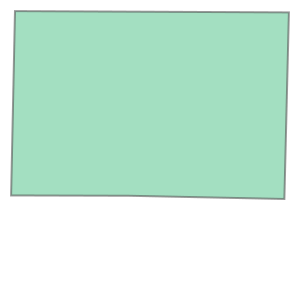

In [5]:
aoi_gdf_shape

#### Plot the AOI

Dimension of the area is 6841 x 4627 meters


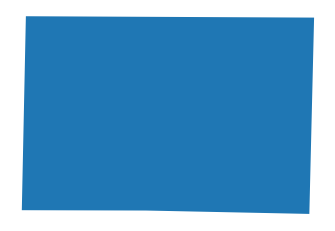

In [6]:
aoi_gdf.plot()
plt.axis('off')
print('Dimension of the area is {0:.0f} x {1:.0f} meters'.format(aoi_gdf_shape.bounds[2] - aoi_gdf_shape.bounds[0], 
                                                                 aoi_gdf_shape.bounds[3] - aoi_gdf_shape.bounds[1]))

#### Get AOI CRS

In [0]:
aoi_gdf_crs = aoi_gdf.crs

In [8]:
aoi_gdf_crs

<Projected CRS: EPSG:25831>
Name: ETRS89 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - 0°E to 6°E and ETRS89 by country
- bounds: (0.0, 37.0, 6.01, 82.41)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Patching operations

The AOI will be tiled in 7 (columns) x 6 (rows).

In [0]:
bbox_splitter = BBoxSplitter([aoi_gdf_shape], aoi_gdf_crs, (7, 6))

In [10]:
print('Area bounding box: {}\n'.format(bbox_splitter.get_area_bbox().__repr__()))

Area bounding box: BBox(((337756.3763814125, 4720966.567856835), (344597.46412394074, 4725593.428824229)), crs=CRS('25831'))



In [11]:
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print('Each bounding box also has some info how it was created. Example:\n'
      '\nbbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

Each bounding box also has some info how it was created. Example:

bbox: BBox(((337756.3763814125, 4720966.567856835), (338733.6746303451, 4721737.711351401)), crs=CRS('25831'))
info: {'parent_bbox': BBox(((337756.3763814125, 4720966.567856835), (344597.46412394074, 4725593.428824229)), crs=CRS('25831')), 'index_x': 0, 'index_y': 0}



In [12]:
len(bbox_splitter.bbox_list)

42

### Save the pickle splitter for latter use

#### Make directory if not exists

In [0]:
if not os.path.isdir(os.path.join(OUTPUT_ETL, 'eolearn-tile-def')):
    os.makedirs(os.path.join(OUTPUT_ETL, 'eolearn-tile-def'))

#### Make pickle

In [0]:
TILE_DF_FOLDER = os.path.join(OUTPUT_ETL, 'eolearn-tile-def')

with open(os.path.join(TILE_DF_FOLDER, 'icgc_bbox_25831_7x6_42.pickle'),'wb') as fp:
    pickle.dump(bbox_splitter, fp)

### Visualize the selection

#### Patch indexes to DataFrame

In [15]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
gdf.head()

index_x  index_y                                           geometry
0        0        0  POLYGON ((337756.376 4720966.568, 337756.376 4...
1        0        1  POLYGON ((337756.376 4721737.711, 337756.376 4...
2        0        2  POLYGON ((337756.376 4722508.855, 337756.376 4...
3        0        3  POLYGON ((337756.376 4723279.998, 337756.376 4...
4        0        4  POLYGON ((337756.376 4724051.142, 337756.376 4...

#### Get labels as GeoDataFrame

In [0]:
labels = gpd.read_file(os.path.join(LABEL_FOLDER, 'cobertes_clipped_icgc2.shp'))

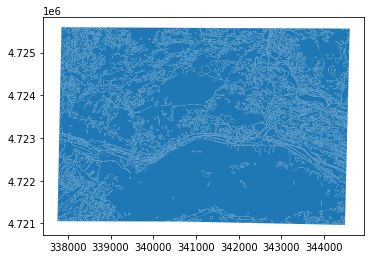

In [18]:
labels.plot()

#### Obtain patch ids

In [0]:
# Obtain patch ids
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    patchIDs.append(idx)

In [20]:
print(patchIDs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


#### Visualize the experiment area

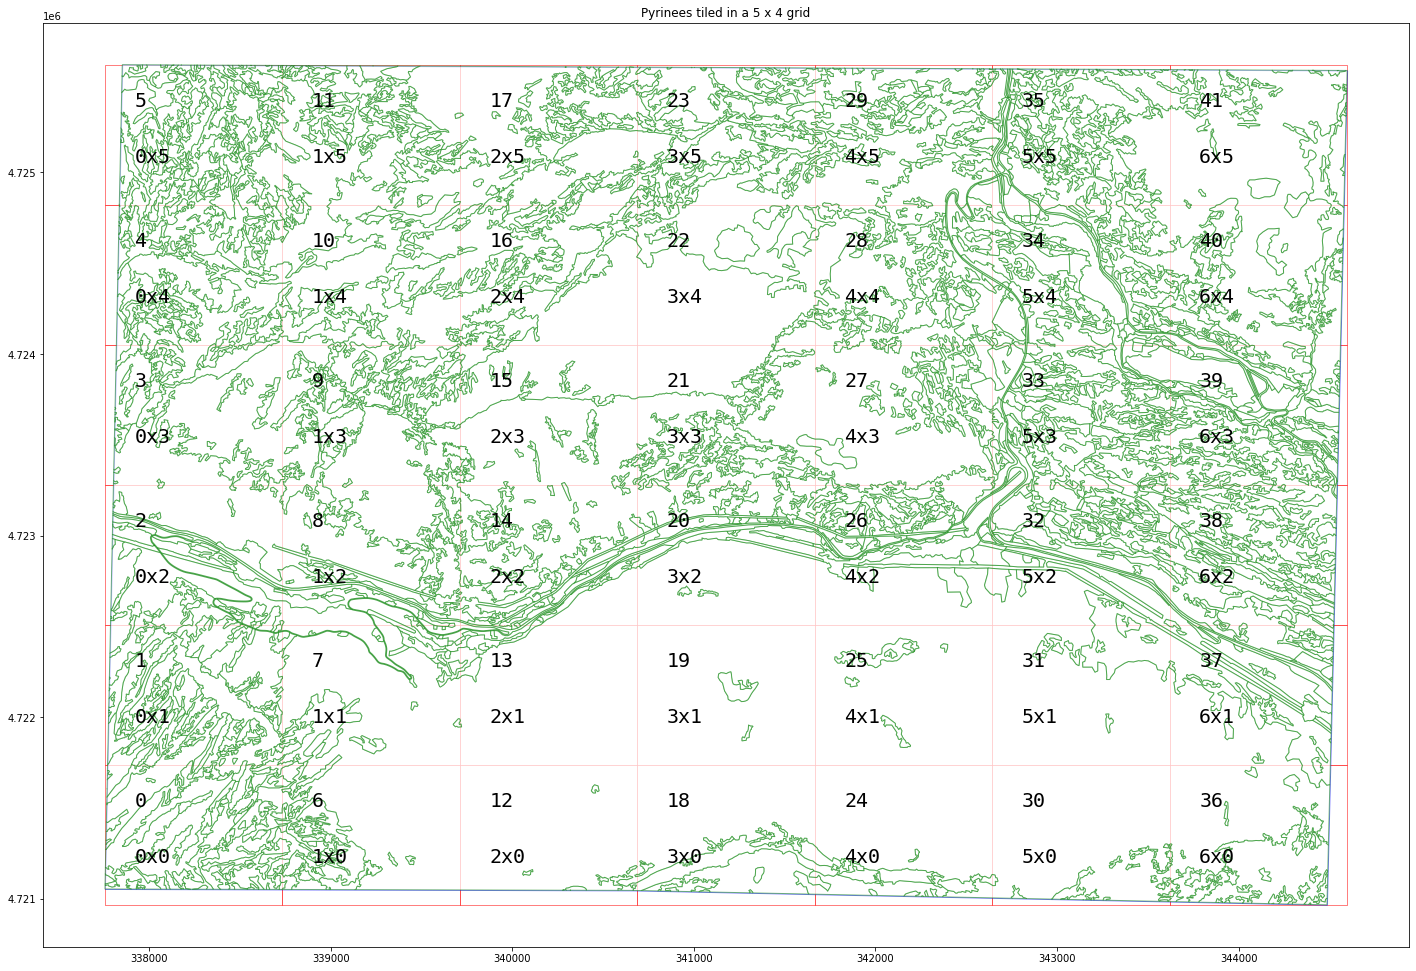

In [21]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 20}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5

# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
aoi_gdf.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
labels.plot(ax=ax, facecolor='w',edgecolor='g',alpha=0.5)
ax.set_title('Pyrinees tiled in a 5 x 4 grid');

# add annotiation text
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

if not os.path.isdir(os.path.join(OUTPUT_ETL, 'figs')):
    os.makedirs(os.path.join(OUTPUT_ETL, 'figs'))
fig.savefig(os.path.join(OUTPUT_ETL, 'figs/aoi_to_tiles.png'), bbox_inches='tight')

#### Open BBoxSplitter with tile definitions

In [0]:
with open(os.path.join(TILE_DF_FOLDER, 'icgc_bbox_25831_7x6_42.pickle'),'rb') as fp:
    bbox_splitter = pickle.load(fp)

##### Get lenght of bbox_list

In [23]:
len(bbox_splitter.bbox_list)

42

##### Print geometries from bbox

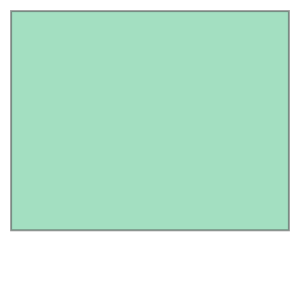

In [24]:
bbox_splitter.bbox_list[1]

##### Get bbox splitter bbox

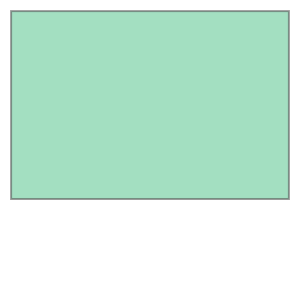

In [25]:
bbox_splitter.get_area_bbox()

In [26]:
bbox_splitter.get_area_bbox().crs

CRS('25831')

# EOlearn IO tasks

## Configure sentinelhub id

In [27]:
!sentinelhub.config --show

{
  "instance_id": "instance_colab",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}
Configuration file location: /usr/local/lib/python3.6/dist-packages/sentinelhub/config.json


In [0]:
! sentinelhub.config --instance_id 'instance_colab'

### EOPatch workflow

#### Getting to know our labels

In [29]:
geodf_label = gpd.read_file(os.path.join(LABEL_FOLDER, 'cobertes_clipped_icgc2.shp'))
a = geodf_label['nivell_2'].unique()
print(sorted(a))

[111, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 232, 234, 341, 344, 345, 346, 347, 349, 350, 351, 352, 461, 463]


#### Remapping those values (too high range)

In [30]:
from collections import defaultdict

dict_change = defaultdict(list)

for idx, val in enumerate(sorted(a)):
    print(idx + 1, val)
    dict_change[val].append(idx + 1)

dict_change

1 111
2 221
3 222
4 223
5 224
6 225
7 226
8 227
9 228
10 229
11 230
12 232
13 234
14 341
15 344
16 345
17 346
18 347
19 349
20 350
21 351
22 352
23 461
24 463


defaultdict(list,
            {111: [1],
             221: [2],
             222: [3],
             223: [4],
             224: [5],
             225: [6],
             226: [7],
             227: [8],
             228: [9],
             229: [10],
             230: [11],
             232: [12],
             234: [13],
             341: [14],
             344: [15],
             345: [16],
             346: [17],
             347: [18],
             349: [19],
             350: [20],
             351: [21],
             352: [22],
             461: [23],
             463: [24]})

In [31]:
geodf_label = geodf_label.replace({'nivell_2': dict_change})
geodf_label

fid  ...                                           geometry
0      536954.0  ...  MULTIPOLYGON (((338404.329 4725590.828, 338432...
1      187516.0  ...  POLYGON ((338540.922 4725473.880, 338529.166 4...
2      187515.0  ...  POLYGON ((338540.922 4725473.880, 338547.166 4...
3      188421.0  ...  MULTIPOLYGON (((339088.173 4725587.610, 339162...
4      536136.0  ...  POLYGON ((338631.166 4725430.282, 338635.666 4...
...         ...  ...                                                ...
1802  1265492.0  ...  POLYGON ((344105.159 4721761.753, 344109.659 4...
1803  1518429.0  ...  POLYGON ((344515.984 4722191.900, 344515.207 4...
1804   376144.0  ...  MULTIPOLYGON (((344576.406 4724690.786, 344575...
1805  1163757.0  ...  POLYGON ((344480.169 4723861.754, 344511.669 4...
1806   789413.0  ...  POLYGON ((344557.738 4723918.713, 344557.175 4...

[1807 rows x 4 columns]

In [32]:
geodf_label['nivell_2'].max()

24

#### Build up the EOlearn task classes

In [0]:
from eolearn.core import EOPatch

class EmptyEOPatch(EOTask):   
    """
    Creates an empty geopatch
    """
    def __init__(self, bounding_box):
        self.bounding_box = bounding_box
    
    def execute(self, bounding_box):
        eopatch = EOPatch()
        eopatch.set_bbox(bounding_box)

        return eopatch

class FillEOPatchRGB(EOTask):
    """
    Fills EOPatch with RGB
    """
    def __init__(self, patch, rgb):
        self.patch = patch
        self.rgb = rgb
    
    def execute(self, patch):
        eopatch = ImportFromTiff(feature=(FeatureType.DATA, 'RGB'), 
                                no_data_value=np.nan)
        eopatch.execute(eopatch=patch, filename=self.rgb)

        # Patch gets updated, need to return this
        return patch
    
class LULC(Enum):
    NO_DATA = (0, 'No Data', 'black')
    AGRICULTURAL_AREA = (1, 'Agro_Area', 'xkcd:lime')
    FOREST_ACICULIFOLIS = (2, 'Forest_Aciculifolis', 'xkcd:darkgreen')
    FOREST_CADUCIFOLIS = (3, 'Forest_Caducifolis', 'orange')
    FOREST_LAURIFOLIS = (4, 'Forest_Laurifolis', 'xkcd:tan')
    BUSHES = (5, 'Bushes', 'xkcd:azure')
    CLEAR_FOREST_ACICUFOLIS = (6, 'Clear_Forest_Acucifolis', 'xkcd:lightblue')
    CLEAR_FOREST_CADUCIFOLIS = (7,  'Clear_Forest_Caducifolis', 'xkcd:beige')
    CLEAR_FOREST_LAURIFOLIS = (8,  'Clear_Forest_Laurifolis', 'xkcd:cyan')
    PASTURES = (9,  'Pastures', 'xkcd:gold')
    FOREST_RIVER = (10,  'Forest_river', 'xkcd:darkgreen')
    CLEAR_FOREST = (11,  'Clear_Forest', 'xkcd:lightgreen')
    ROCKY_FOREST = (12,  'Rocky_Forest', 'xkcd:grey')
    WETLAND_FOREST = (13,  'Wetland_forest', 'xkcd:khaki')
    URBAN_AREA = (14,  'Urban_area', 'xkcd:lightblue')
    ISOLATED_URBAN_AREA = (15,  'Isolated_urban_area', 'xkcd:aqua')
    ISOLATED_RESIDENTIAL_AREA = (16,  'Isolated_residential_area', 'xkcd:silver')
    URBAN_GREEN_AREA = (17, 'Urban_green_area', 'xkcd:olive')
    INDUSTRIAL_AREA = (18, 'Industrial_area', 'xkcd:teal')
    MINING_AREA = (19, 'Mining_area', 'xkcd:wheat')
    CONSTRUCTION_AREA = (20, 'Construction_area', 'xkcd:navy')
    TRANSPORTATION_WAYS = (21, 'Transportation_ways', 'xkcd:azure')
    CLEAR_URBAN_AREA = (22, 'Clear_urban_area', 'xkcd:brown')
    RESERVOIR = (23, 'Reservoir', 'xkcd:darkblue')
    RIVERS = (24, 'Rivers', 'xkcd:blue')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

class FillEOPatchLabels(EOTask):
    """
    Fills EOPatch with labels
    """
    def __init__(self, patch, gdf, feature_column, resolution, nodataval):
        self.patch = patch
        self.gdf = gdf
        self.feature_column = feature_column
        self.resolution = resolution
        self.nodataval = nodataval
    
    def execute(self, patch):

        rasterized_annotation = VectorToRaster(vector_input=self.gdf, 
                                               raster_feature=(FeatureType.MASK_TIMELESS, 'LULC'), 
                                               values_column=self.feature_column,
                                               raster_resolution=self.resolution,
                                               no_data_value=self.nodataval,
                                               raster_dtype=np.uint16)
        rasterized_annotation.execute(eopatch=patch)

        # Patch gets updated, need to return this
        return patch

class SaveEOPatch(EOTask):
    """
    Save a Patch
    """
    def __init__(self, input_patch, output_folder):
        self.input_patch = input_patch
        self.output_folder = output_folder
    
    def execute(self, input_patch, output_folder):
        if not os.path.isdir(output_folder):
            os.makedirs(output_folder)

        input_patch.save(path=output_folder, overwrite_permission=1)

        return input_patch

In [0]:
path = os.path.join(OUTPUT_ETL, 'EOPATCH_2')

if not os.path.isdir(path):
    os.makedirs(path)

#### Build workflow

In [35]:
[entry.color for entry in LULC]

['black',
 'xkcd:lime',
 'xkcd:darkgreen',
 'orange',
 'xkcd:tan',
 'xkcd:azure',
 'xkcd:lightblue',
 'xkcd:beige',
 'xkcd:cyan',
 'xkcd:gold',
 'xkcd:darkgreen',
 'xkcd:lightgreen',
 'xkcd:grey',
 'xkcd:khaki',
 'xkcd:lightblue',
 'xkcd:aqua',
 'xkcd:silver',
 'xkcd:olive',
 'xkcd:teal',
 'xkcd:wheat',
 'xkcd:navy',
 'xkcd:azure',
 'xkcd:brown',
 'xkcd:darkblue',
 'xkcd:blue']

In [0]:
## Define tasks per workflow

eopatch = EmptyEOPatch(bounding_box=bbox_splitter.get_area_bbox())

rgb_patch = FillEOPatchRGB(patch=eopatch, rgb=DATA_TIF)

## Define map colors
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)
                                    
## Define labels
label_patch = FillEOPatchLabels(patch=rgb_patch, 
                                gdf=geodf_label, 
                                feature_column='nivell_2',
                                resolution=0.25, 
                                nodataval=0)

save = SaveEOPatch(input_patch=label_patch, output_folder=path)

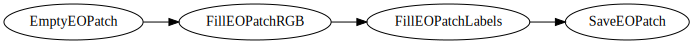

In [37]:
# Define the workflow
workflow = LinearWorkflow(eopatch, rgb_patch, label_patch, save)

# Let's visualize it
workflow.dependency_graph()

#### Run executin args

In [38]:
%%time

# Execute the workflow
# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_splitter.bbox_list):
    execution_args.append({
        eopatch: {'bounding_box': bbox},
        save: {'output_folder': os.path.join(path, 'eopatch_{}'.format(idx))}
    })

CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 1.41 ms


#### Run Eolearn executor

In [0]:
#executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=OUTPUT_REPORT)
#executor.run(workers=5, multiprocess=True)

#executor.make_report()

# Dataset visualization

In [0]:
eopatch = EOPatch.load('{}/eopatch_1'.format(path), lazy_loading=True)

In [39]:
eopatch

EOPatch(
  data: {
    RGB: FeatureIO(/data/RGB.npy)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: FeatureIO(/mask_timeless/LULC.npy)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((337756.3763814125, 4721737.711351401), (338733.6746303451, 4722508.854845966)), crs=CRS('25831'))
  timestamp: []
)

In [40]:
eopatch.data['RGB'].min()

nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


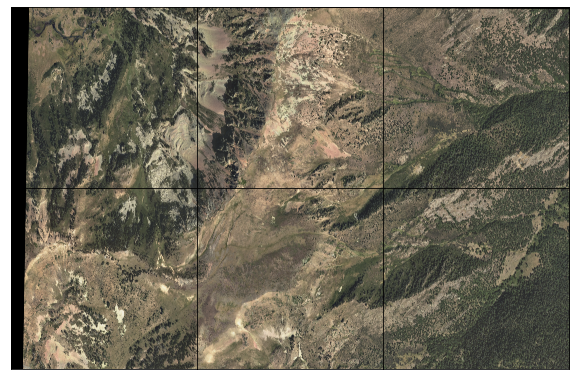

In [41]:
# Draw the RGB image
fig = plt.figure(figsize=(10, 10))

list_tiles = [5, 11, 17, 4, 10, 16]
pbar = tqdm(total=len(list_tiles))

for idx, val in enumerate(list_tiles):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path, val), lazy_loading=True)
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(eopatch.data['RGB'][0].astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


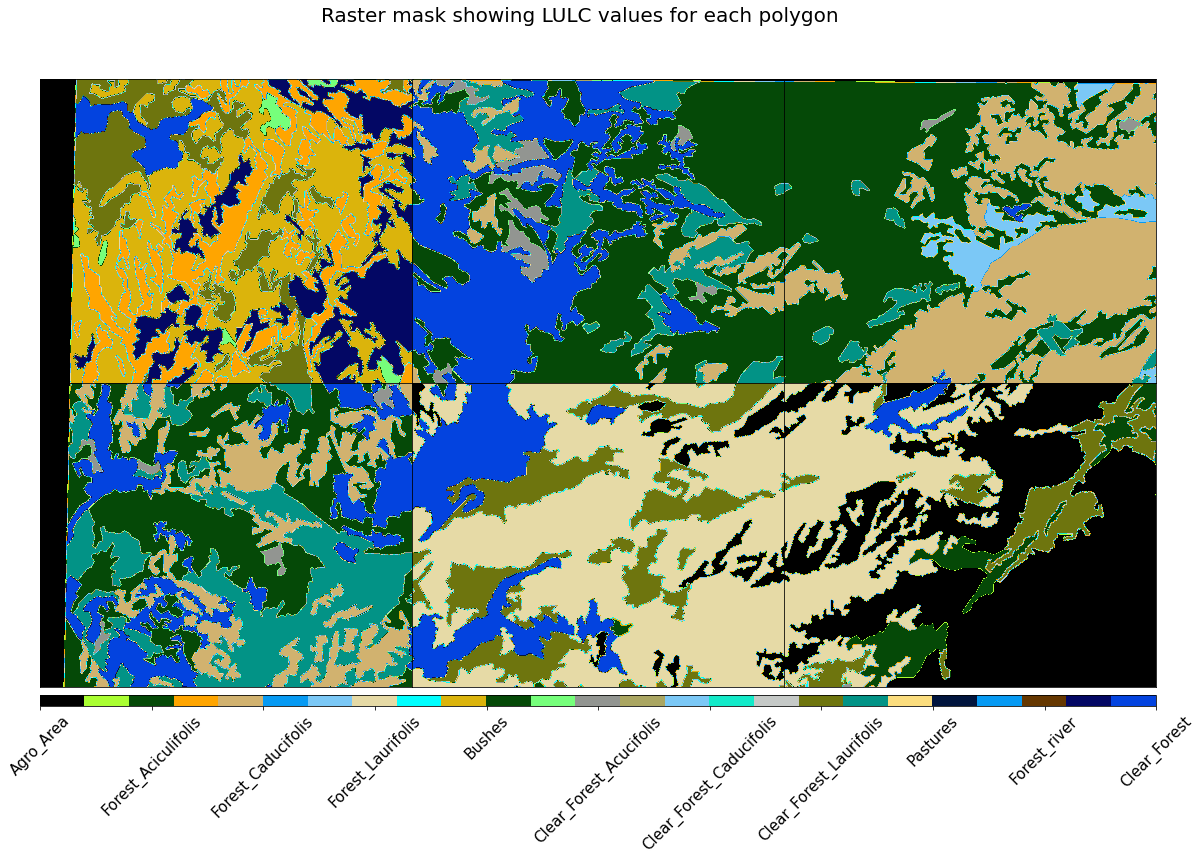

In [42]:
# Draw the LABEL images
fig = plt.figure(figsize=(20, 20))

list_tiles = [5, 11, 17, 4, 10, 16]
pbar = tqdm(total=len(list_tiles))

for idx, val in enumerate(list_tiles):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path, val), lazy_loading=True)
    ax = plt.subplot(3, 3, idx + 1)
    im = ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap)
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
cb.set_ticks([entry.id+1 for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)

fig.suptitle('Raster mask showing LULC values for each polygon', y=0.93, size=20)

plt.show()

In [0]:
eopatch_example = EOPatch.load('{}/eopatch_1'.format(path), lazy_loading=True)

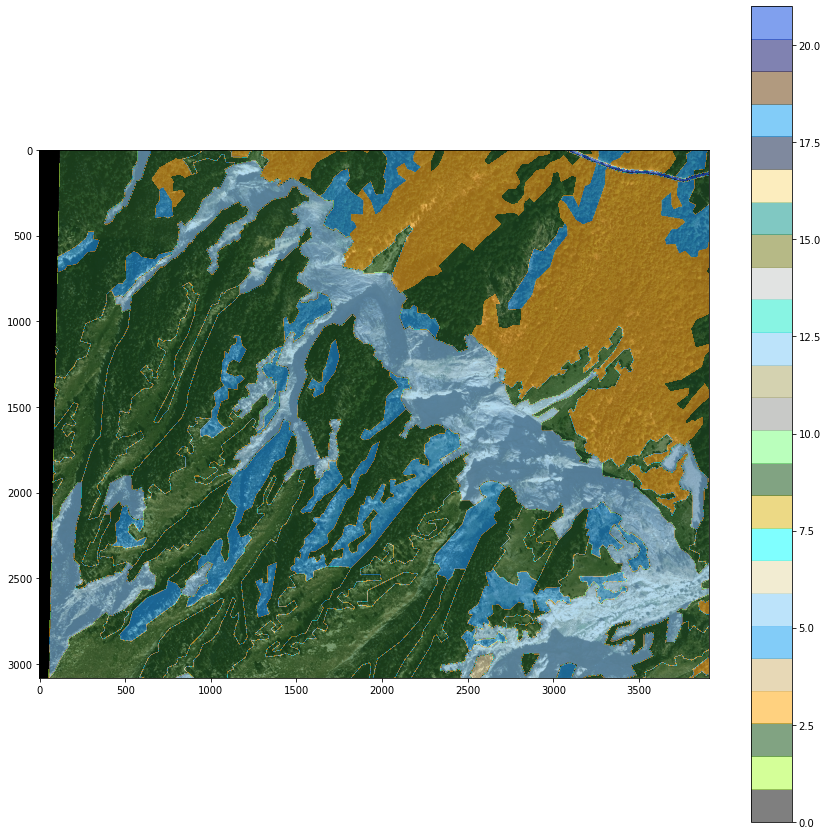

In [44]:
data = eopatch_example.data['RGB'][0].astype(np.uint8)
plt.figure(figsize=(15,15))
plt.imshow(data)

lulc_classes = eopatch_example.mask_timeless['LULC'].squeeze()
plt.imshow(lulc_classes, alpha=.5, cmap=lulc_cmap)
plt.colorbar()

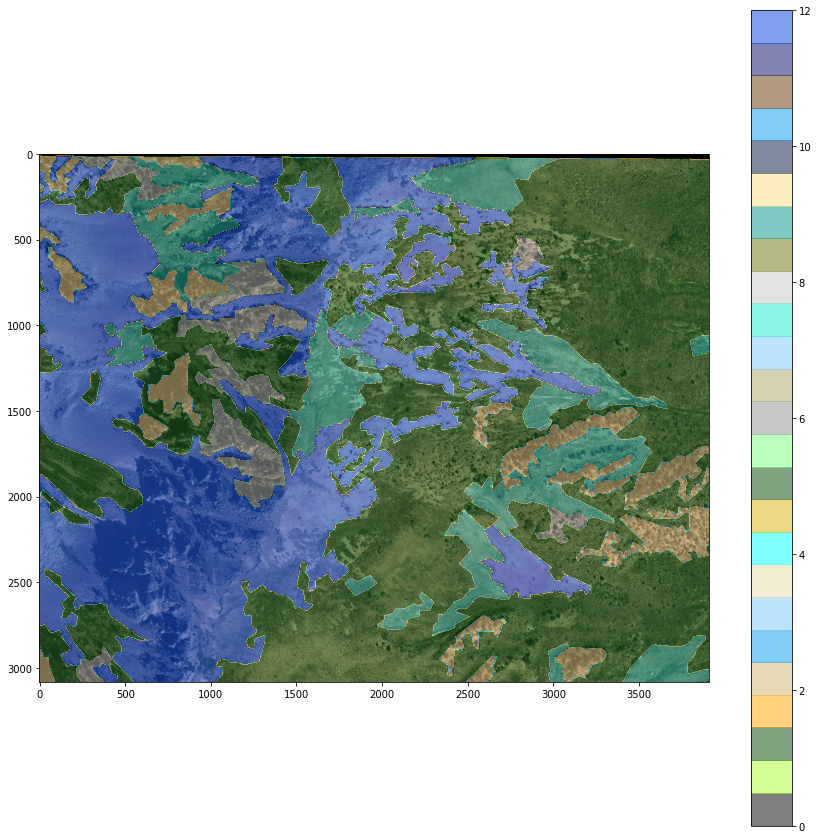

In [45]:
eopatch_example11 = EOPatch.load('{}/eopatch_11'.format(path), lazy_loading=True)

data = eopatch_example11.data['RGB'][0].astype(np.uint8)
plt.figure(figsize=(15,15))
plt.imshow(data)

lulc_classes11 = eopatch_example11.mask_timeless['LULC'].squeeze()
plt.imshow(lulc_classes11, alpha=.5, cmap=lulc_cmap)
plt.colorbar()

### Export to tiff

In [46]:
ExportToTiff(feature=(FeatureType.DATA, 'RGB')).execute(eopatch_example11, 
                                                        filename=os.path.join(OUTPUT_ETL, '11_data.tif'))

EOPatch(
  data: {
    RGB: numpy.ndarray(shape=(1, 3085, 3909, 3), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(3085, 3909, 1), dtype=uint16)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((338733.6746303451, 4724822.285329663), (339710.9728792777, 4725593.428824229)), crs=CRS('25831'))
  timestamp: []
)

In [47]:
ExportToTiff(feature=(FeatureType.MASK_TIMELESS, 'LULC')).execute(eopatch_example11, 
                                                        filename=os.path.join(OUTPUT_ETL, '11_label.tif'))

EOPatch(
  data: {
    RGB: numpy.ndarray(shape=(1, 3085, 3909, 3), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(3085, 3909, 1), dtype=uint16)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((338733.6746303451, 4724822.285329663), (339710.9728792777, 4725593.428824229)), crs=CRS('25831'))
  timestamp: []
)

# Prepare dataset for training

The patches are split into a train and test subset, where we take the patch with ID = 1 for testing, since it seems a good representative of the area.

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features, with $f$ the size of bands and band combinations  and $t$ the length of the resampled time-series

In [0]:
# load sampled eopatches
eopatches = []
subset_idx = len(bbox_splitter.bbox_list)

for i in range(0, subset_idx):
    eopatches.append(EOPatch.load('{}/eopatch_{}'.format(path, i), lazy_loading=True))    

eopatches = np.array(eopatches)

### Dataset Generator

In [40]:
eop = EOPatch.load('{}/eopatch_11'.format(path), lazy_loading=True)
eop.data['RGB'].shape

(1, 3085, 3909, 3)

In [41]:
np.resize((eop.data['RGB'][0].astype(np.uint8)), (3085, 3909, 3))

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[46, 46, 45],
        [47, 47, 46],
        [46, 46, 46],
        ...,
        [75, 81, 64],
        [75, 81, 64],
        [81, 86, 68]],

       [[45, 45, 45],
        [46, 46, 46],
        [46, 46, 47],
        ...,
        [63, 68, 51],
        [62, 67, 50],
        [64, 69, 51]],

       [[46, 46, 47],
        [47, 47, 49],
        [47, 47, 50],
        ...,
        [64, 68, 51],
        [69, 73, 56],
        [63, 68, 50]]], dtype=uint8)

In [42]:
np.resize((eop.mask_timeless['LULC'].squeeze()), (3085, 3909))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 5, 5, 5],
       [2, 2, 2, ..., 5, 5, 5]], dtype=uint16)

#### X_train and X_test splits

In [0]:
from sklearn.model_selection import train_test_split

id_list = [i for i in np.arange(0, len(eopatches))]

X_train, X_test, y_train, y_test = train_test_split(id_list, id_list, test_size=0.33, random_state=42)

In [44]:
X_train

[15,
 33,
 16,
 36,
 35,
 0,
 24,
 5,
 11,
 40,
 1,
 31,
 21,
 2,
 32,
 41,
 3,
 37,
 23,
 34,
 10,
 22,
 18,
 20,
 7,
 14,
 28,
 38]

In [45]:
X_test

[25, 13, 8, 26, 4, 39, 19, 29, 30, 6, 27, 12, 17, 9]

In [46]:
len(X_train)

28

### Create cropping masks

In [0]:
def crop_center_rgb(img,cropx,cropy):
    y,x,ch = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx, :]

In [0]:
def crop_center_lulc(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [0]:
width_reduced = 224

In [0]:
height_reduced = 224

In [0]:
import numpy as np
import keras
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, path, list_IDs, n_classes, batch_size=1,n_channels=3, shuffle=True):
        'Initialization'
        self.path = path
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, width_reduced, height_reduced, 3))
        y = np.empty((self.batch_size, width_reduced, height_reduced))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            eopatch = EOPatch.load('{}/eopatch_{}'.format(path, ID), lazy_loading=True)

            # Store sample
            X[i,] = crop_center_rgb(eopatch.data['RGB'][0].astype(np.uint8), width_reduced, height_reduced)
            #X[i,] = np.resize((eop.data['RGB'][0].astype(np.uint8)), (width_reduced, height_reduced, 3))

            # Store class
            y[i] = crop_center_lulc(eopatch.mask_timeless['LULC'].squeeze(), width_reduced, height_reduced)
            #y[i] = np.resize((eop.mask_timeless['LULC'].squeeze()), (width_reduced, height_reduced))

            del eopatch

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [0]:
training_generator = DataGenerator(path=path, 
                                   list_IDs=X_train,
                                   n_classes=len([entry.class_name for entry in LULC]))

In [0]:
validation_generator = DataGenerator(path=path, 
                                   list_IDs=X_test,
                                   n_classes=len([entry.class_name for entry in LULC]))

### Define the UNET

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Cropping2D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [0]:
def unet(input_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = "categorical_crossentropy", 
                  metrics = ['accuracy'])

    return model

model = unet(input_size = (height_reduced, width_reduced, 3))

# Train dataset

Feel free to try with different optimizers if your training does not look too good

In [125]:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    verbose=1, epochs=3)

Epoch 1/3
28/28 [==============================] - 137s 5s/step - loss: 1.1921e-07 - accuracy: 0.9600 - val_loss: 1.1921e-07 - val_accuracy: 0.9600
Epoch 2/3
28/28 [==============================] - 136s 5s/step - loss: 1.1921e-07 - accuracy: 0.9600 - val_loss: 1.1921e-07 - val_accuracy: 0.9600
Epoch 3/3
28/28 [==============================] - 137s 5s/step - loss: 1.1921e-07 - accuracy: 0.9600 - val_loss: 1.1921e-07 - val_accuracy: 0.9600


# Validate model and show results

In [0]:
predict = model.predict_generator(validation_generator)

In [127]:
len(predict)

14

In [137]:
X_test[13]

9

In [0]:
eop = EOPatch.load('{}/eopatch_{}'.format(path, X_test[13]), lazy_loading=True)

In [0]:
label = crop_center_lulc(eop.mask_timeless['LULC'].squeeze(), 512, 512)

In [0]:
img = crop_center_rgb(eop.data['RGB'][0].astype(np.uint8), 512, 512)

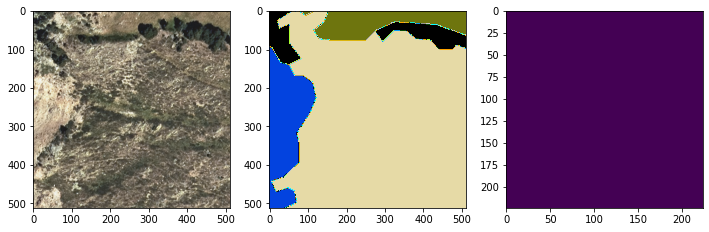

In [142]:
p = np.argmax(predict, axis=3)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(label, cmap=lulc_cmap)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(p[0])

# What we will see in next class

* Class balancing
* Sliding window
* Memory optimization

# Exercise: let's put all this into a package!

Let's package all this!

# Exercise: try to change to a binary classification problem

Change values in FillEOPatch labels